# Figure 3: Simulations analysis

Hail and reporting functions estimated by each of the three experiments on one synthetic dataset. The functions used to generate the data are given by the black dashed line and the 50% and 95% credible intervals are shaded. The corresponding values of the LOOCV ELPD estimate are given in each figure.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(patchwork)
  library(latex2exp, lib.loc = additional_package_lib)
  library(posterior, lib.loc = additional_package_lib)
  library(janitor, lib.loc = additional_package_lib)
  library(scico)
})

In [2]:
# inverse logit
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

Note that this function does not need the Yeo-Johnson transform as the simulations assume $\alpha_3$ and $\beta_3$ are known.

In [3]:
function_quantiles_from_draws_no_transform <- function(x_matrix, par_matrix, var, regime){
  # (Simplified) function which, given a matrix at which to evaluate the probability,
  # will employ the given simulation draws to calculate quantiles of said
  # probability at each evaluation point. 
  # 
  # Inputs:
  #  x_matrix      matrix (neval x npars)
  #                each row representats a point at which to evaluate
  #                the probability and calculate its statistics
  #  par_matrix    matrix (ndraws x npars)
  #                contains draws of the parameters from stan
  #  name          str
  #                used to name the columns of the resulting tibble
  #
  # Outputs:
  #  _             tibble (neval x 8)
  #                each row corresponds to a row in x_matrix with columns
  #                corresponding to statistics (e.g. <name>_2_5_percent, ...)
  
  # create mat_func: matrix with probability at each x location (row) for 
  # the number of simulations (col)
  
  # since no transform can just multiply directly
  mat_func <- inv_logit(x_matrix %*% t(par_matrix))
    
  # using apply to take quantiles over matrix
  quantiles_tibble <- apply(mat_func, MARGIN = 1, FUN = quantile, 
    probs = c(0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975)) %>%
    t() %>%
    # adding row means 
    cbind(mean = rowMeans(mat_func)) %>% 
    # converting to tibble
    as_tibble(.name_repair = "unique") %>% 
    # rename: <NAME>_2_5_percent, <NAME>_5_percent, etc.
    rename_with(~ paste("var", gsub("x", "", make_clean_names(.x)), sep = "_"))
  if (var == "report") {
    quantiles_tibble %>%
      # exponentiates column as was logarithm
      add_column(x = exp(x_matrix[, 2])) %>%
      mutate(true = inv_logit(x_matrix %*% params_list[[paste(regime, "beta", var, sep = "_")]]))
  } else {
    quantiles_tibble %>%
      # no need to transform mesh
      add_column(x = x_matrix[, 2]) %>%
      mutate(true = inv_logit(x_matrix %*% params_list[[paste(regime, "beta", var, sep = "_")]]))
  }
}

In [4]:
make_tibble_for_plot <- function(model_name, var){
  # Make a tibble with the hail or reporting functions for the LHHR and HHLR 
  # experiments under some prior regime to be plotted.
  # 
  # Inputs:
  #  model_name  str
  #              name of the model as saved in /g/data  
  #              doesn't matter if LHHR or HHLR is given as plot contains both
  #  var         str
  #              variable of interest (hail or report)
  #
  # Outputs:
  #  _           tibble
  #              columns giving quantiles of the functions, rows giving x
  #              values, regime indicating LHHR or HHLR

  # has an LHHR model been passed?
  is_lhhr <- str_detect(model_name, "lhhr")
    
  # key params for the first model
  key_params1 <- readRDS(paste(base_dir, 
                               model_name, 
                               "results", 
                               paste0(model_name, "_model_params_full.rds"), sep = "/"))
  # model name for the other model (i.e. if LHHR is given get HHLR)
  opposing_model_name <- ifelse(is_lhhr, 
                                str_replace(model_name, "lhhr", "hhlr"), 
                                str_replace(model_name, "hhlr", "lhhr"))
  # getting key params for second model
  key_params2 <- readRDS(paste(base_dir, 
                               opposing_model_name, 
                               "results", 
                               paste0(opposing_model_name, "_model_params_full.rds"), sep = "/"))
  
  # correct plotting matrix given variable
  if (var == "hail"){
    x_matrix <- x_mesh_matrix
  } else {
    # is already logged
    x_matrix <- x_pop_dens_matrix
  }

  # suppresses warning around metadata removal when selecting columns
  df1 <- suppressWarnings(
           function_quantiles_from_draws_no_transform(x_matrix, 
                                                      key_params1 %>%
                                                        as_draws_df() %>%
                                                        select(starts_with(paste0("beta_", var))) %>%
                                                        select(-contains("raw")),
                                                      var,
                                                      ifelse(is_lhhr, "lhhr", "hhlr"))
  )
  # again getting quantiles and removing warnings
  df2 <- suppressWarnings(
      function_quantiles_from_draws_no_transform(x_matrix,
                                                 key_params2 %>%
                                                   as_draws_df() %>%
                                                   select(starts_with(paste0("beta_", var))) %>%
                                                   select(-contains("raw")),
                                                   var,
                                                   ifelse(is_lhhr, "hhlr", "lhhr"))
  )

  # binding rows with indicator of regime
  if (is_lhhr) {
    bind_rows(list(LHHR = df1, HHLR = df2), .id = "regime")
  } else {
    bind_rows(list(HHLR = df1, LHHR = df2), .id = "regime")
  }
}

In [5]:
get_loocv_estimate <- function(model_name){
  # Get ELPD estimate for a given model name
  # 
  # Inputs:
  #  model_name  str
  #              name of the model as saved in /g/data  
  #
  # Outputs:
  #  _           float
  #              the ELPD estimate

  # get matrix from eval folder
  estimates_matrix <- readRDS(paste(base_dir, model_name, "eval", "loo_object.rds", sep = "/")) %>% 
    pluck("estimates")
    
  # entry in the 1, 1 position
  estimates_matrix[1, 1]
}

In [6]:
get_annotation_small <- function(model_name){ 
  # Pretty print the ELPD as annotation for the plot
  # 
  # Inputs:
  #  model_name  str
  #              name of the model as saved in /g/data  
  #
  # Outputs:
  #  _           str
  #              of form ELPD = <number>.<2dp>

  paste("ELPD =", round(get_loocv_estimate(model_name), 2))
}


make_single_model_plot_small <- function(model_name, var){
  # Plot for one prior with the hail or reporting functions and the resulting
  # ELPD estimates for the LHHR and HHLR estimates
  # 
  # Inputs:
  #  model_name  str
  #              name of the model as saved in /g/data  
  #              doesn't matter if LHHR or HHLR is given as plot contains both
  #  var         str
  #              variable of interest (hail or report)
  #
  # Outputs:
  #  _           ggplot object
  #              plot as described above
    
  # axis labels
  x_lab <- ifelse(var == "hail", "MESH [mm]", TeX("Population Density [people km$^{-2}$]"))
  y_lab <- ifelse(var == "hail", "Posterior P(Hail = 1| MESH)", "Posterior P(Report = 1| Hail = 1, Pop. dens.)")
  
  # what the priors are 
  priors <- case_when(
                      str_detect(model_name, "uninformative") ~ "Weakly informative",
                      str_detect(model_name, "misinformative") ~ "Misleading",
                      str_detect(model_name, "informative") ~ "Strongly informative"
  )
    
  # putting all together into title
  title <- paste(priors, "priors")

  # confidence bounds 
  label_inner <- "95%"
  label_outer <- "50%"
    
  # colour params
  palette <- "batlow"
  begin <- 0.2
  end <- 0.8
  hex_colours <- scico::scico(n = 2, palette = palette, begin = begin, end = end) 
  
  # size params
  base_size <- 16
  
  # ELPD estiamtes for annotation
  model_name_lhhr <- str_replace(model_name, "hhlr", "lhhr")
  model_name_hhlr <- str_replace(model_name_lhhr, "lhhr", "hhlr")
  lhhr_annotation <- get_annotation_small(model_name_lhhr)
  hhlr_annotation <- get_annotation_small(model_name_hhlr)

  # plotting
  p <- make_tibble_for_plot(model_name, var) %>%
    ggplot(aes(x = x)) +
    # posterior mean as solid line
    geom_line(aes(y = var_mean, color = regime)) + 
    # truth as dotted line (black for LHHR and HHLR)
    geom_line(aes(y = true, group = regime), linetype = "dotdash", color = "black") +
    # outer confidence bounds (95%)
    geom_ribbon(aes(ymin = var_2_5_percent, ymax = var_97_5_percent, fill = regime), alpha = 0.3) + 
    # inner confidence bounds (50%)
    geom_ribbon(aes(ymin = var_25_percent, ymax = var_75_percent, fill = regime), alpha = 0.5) +
    # labels
    xlab(x_lab) + 
    ylab(y_lab) +
    ggtitle(title) +
    labs(fill = "Regime", color = "Regime") +
    # size
    theme_gray(base_size = base_size) +
    # colour
    scale_color_scico_d(palette = palette, begin = begin, end = end) + # scico colours
    scale_fill_scico_d(palette = palette, begin = begin, end = end)    # scico fill

  # annotation with ELPD estimate, position depends on variable
  if (var == "report") {
    p + 
      # pop dens is plotted log 10
      scale_x_log10() +
      annotate("text", x = 3, y = 0.95, color = hex_colours[2], label = lhhr_annotation, size = 6, hjust = 0) +
      annotate("text", x = 300, y = 0.05, color = hex_colours[1], label = hhlr_annotation, size = 6, hjust = 0)  
  } else {
    p +
      annotate("text", x = 100, y = 0.05, color = hex_colours[2], label = lhhr_annotation, size = 6, hjust = 0) +
      annotate("text", x = -5, y = 0.95, color = hex_colours[1], label = hhlr_annotation, size = 6, hjust = 0)
  }
}

## Reading in data and setting constants

In [7]:
# base dir where data is located
base_dir <- "/g/data/w42/ig1052/bayesian_paper_data/model_eval"

# read in model data
model_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_",
                              "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                              "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_-26.50_0.25.csv"),
                       col_types = "nnTnnnnnnncnnfffff")

# true parameters
params_list <- list("lhhr_beta_hail" = c(-7, 0.0932),
                    "lhhr_beta_report" = c(-2, 1),
                    "hhlr_beta_hail" = c(-8, 0.3),
                    "hhlr_beta_report" = c(-4.258, 0.5))

## Plotting

In [8]:
# number of points at which to evaluate the hail and reporting functions
n_func_eval <- 100 

# defining x_mesh vector and corresponding matrix using min and max in data
x_mesh <- seq(min(model_data$mesh), max(model_data$mesh), length.out = n_func_eval)
x_mesh_matrix <- matrix(c(rep(1, n_func_eval), x_mesh), ncol = 2)

# defining x_pop_dens and corresponding matrix again with min and max in data
# note the logarithm as model defined in terms of logarithm (exponentiated before plotting)
x_pop_dens <- seq(min(log(model_data$pop_dens)), max(log(model_data$pop_dens)),
                  length.out = n_func_eval)
x_pop_dens_matrix <- matrix(c(rep(1, n_func_eval), x_pop_dens), ncol = 2)

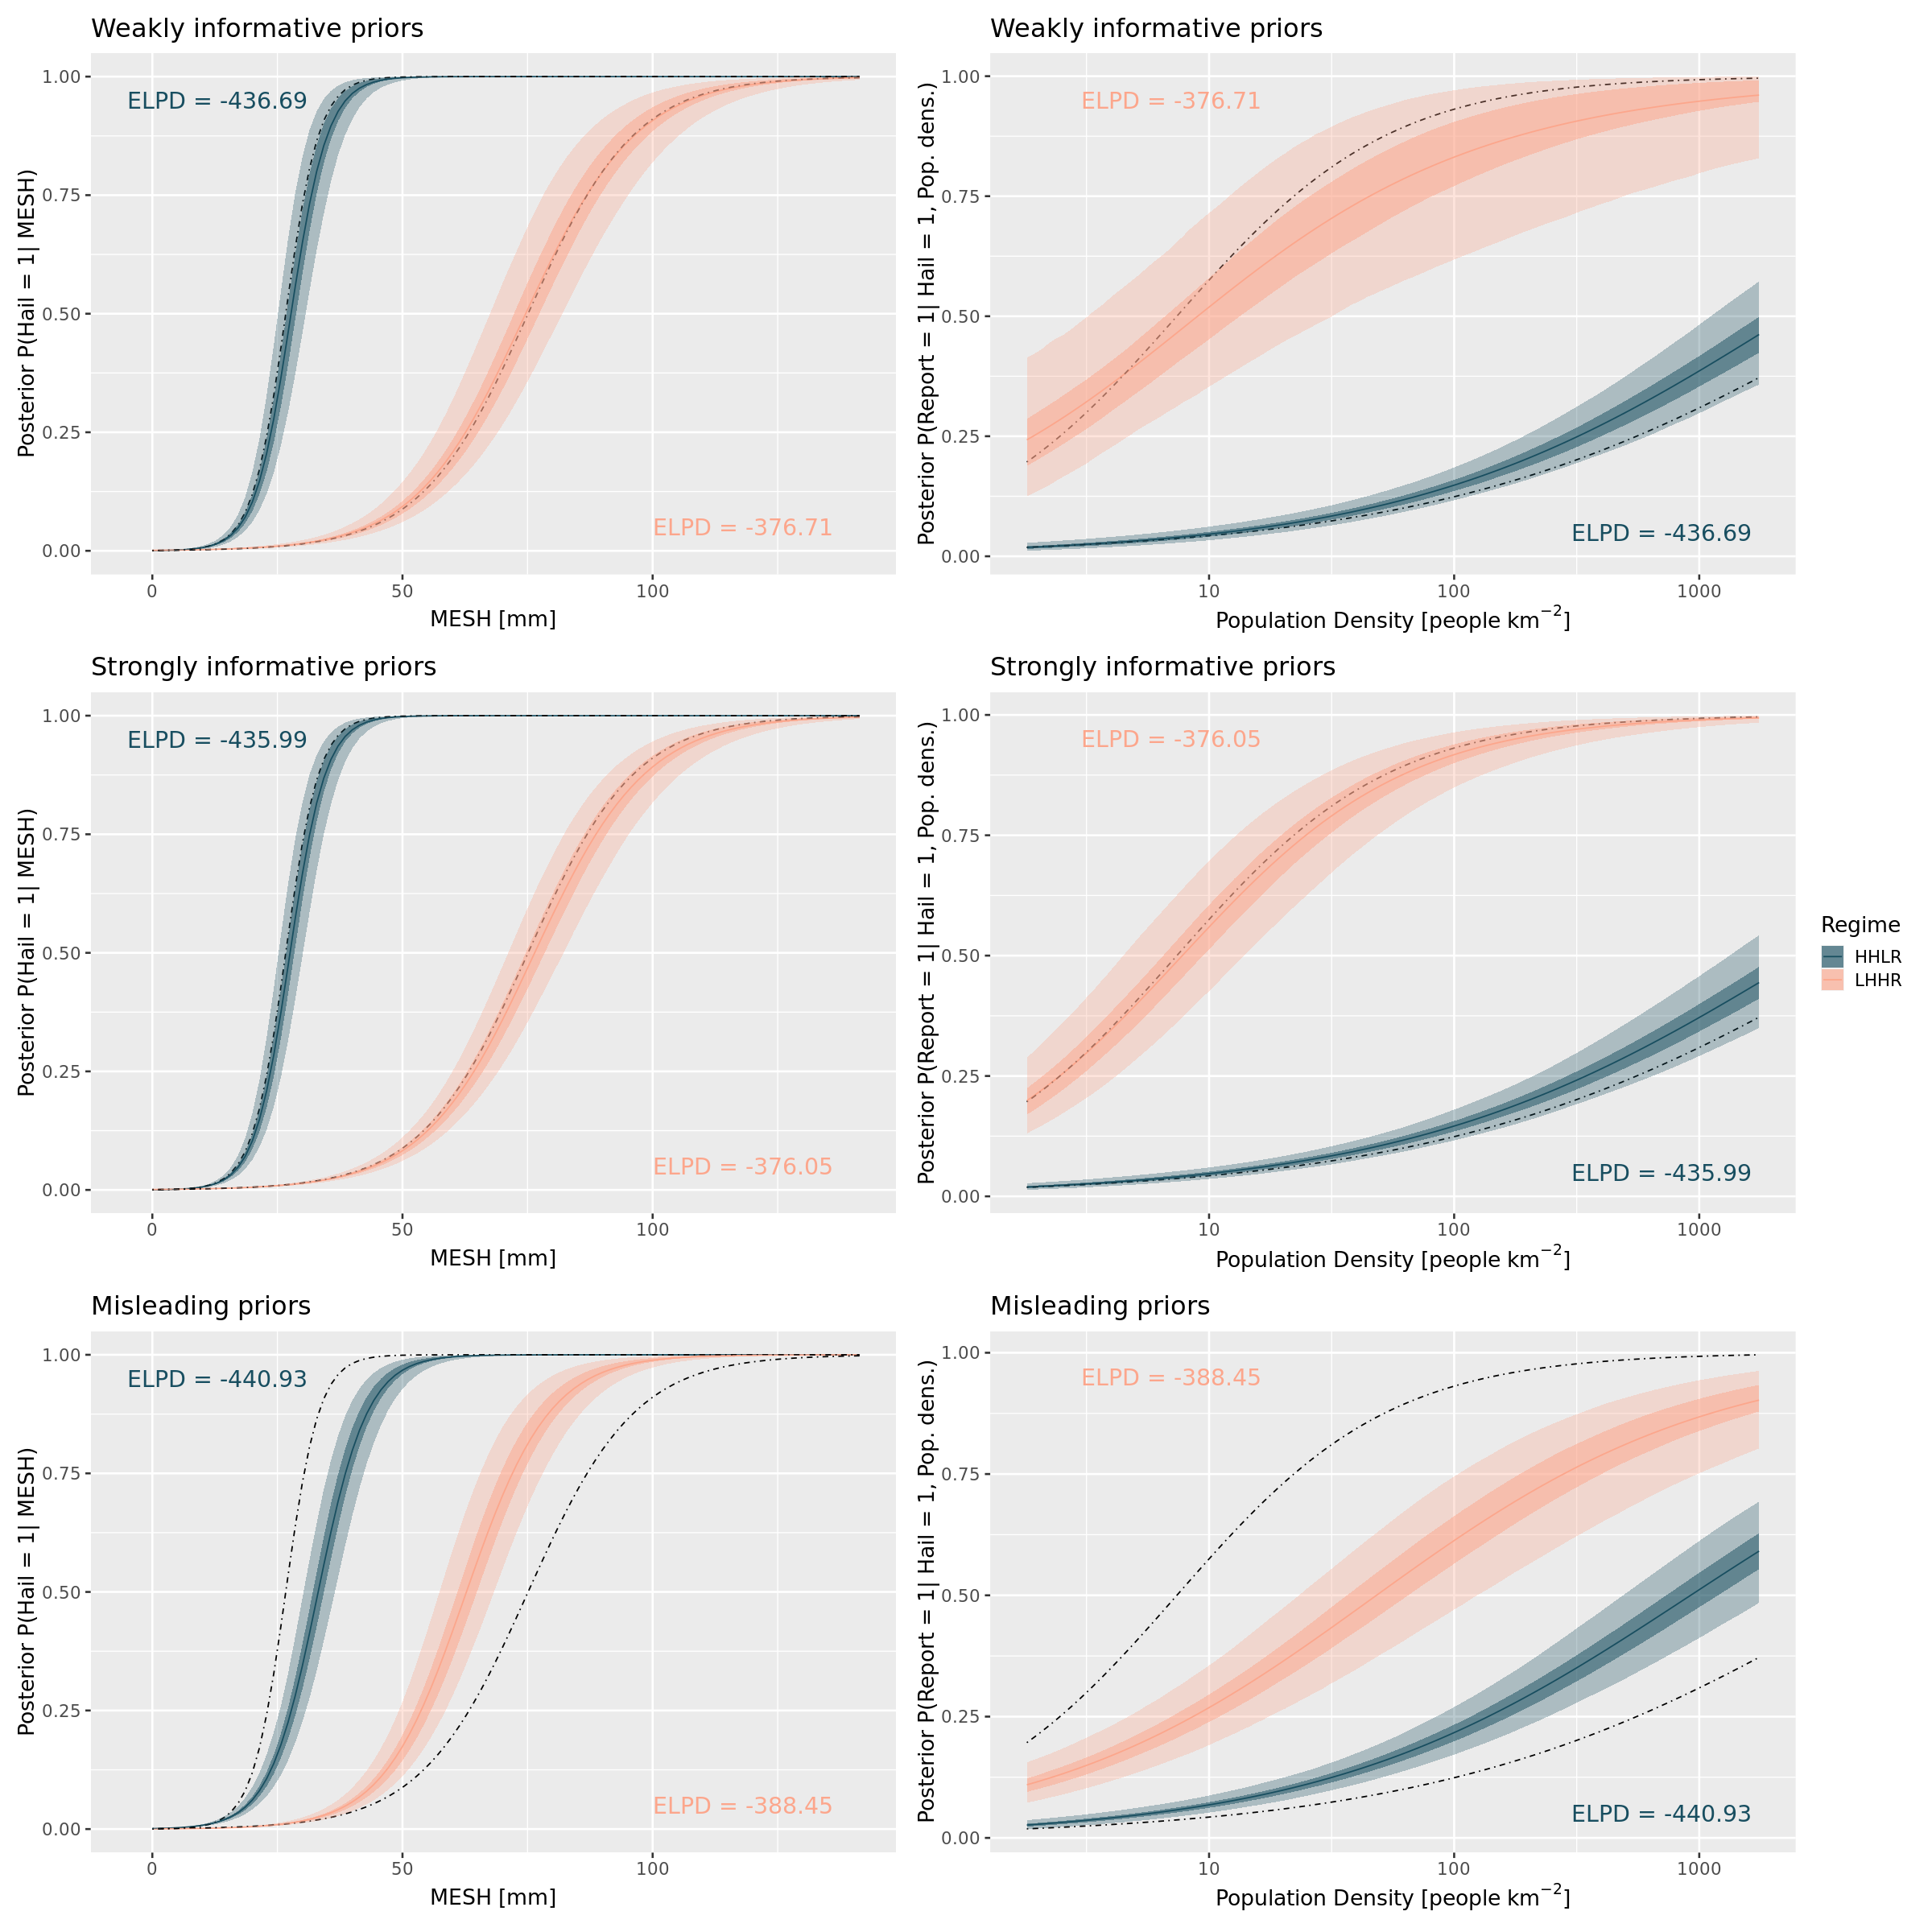

In [9]:
# viewing size
options(repr.plot.width = 20, repr.plot.height = 20)

# model names we're interested in 
model_names <- c("sim_hail_mesh_report_dens_lhhr_uninformative", 
                 "sim_hail_mesh_report_dens_lhhr_informative",
                 "sim_hail_mesh_report_dens_lhhr_misinformative")

# corresponding titles
plot_titles <- c("Strongly informative priors", "Weakly informative priors", "Misleading priors")

plot_list_hail <- map(model_names, \(x) make_single_model_plot_small(x, "hail")) 
plot_list_report <- map(model_names, \(x) make_single_model_plot_small(x, "report")) 

# wraps plots into one figure and collects legends 
c(plot_list_hail, plot_list_report) %>%
    wrap_plots(guides = "collect", nrow = 3, byrow = FALSE)